# Harmonic fit to wind stress curl and zonal wind stress
## Tech preamble

In [1]:
%matplotlib inline
from pathlib import Path
import os
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import numpy as np
import xarray as xr
import xscale.signal.fitting as xfit
import dask
from dask.distributed import Client
from datetime import timedelta
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

/gxfs_work/geomar/smomw294/.conda/envs/py3_std/lib/python3.9/site-packages/xscale-0.1.dev0+35.ga804866-py3.9.egg/xscale/signal/generator.py:48: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def ar(coeffs, n, c=0.):


## Dask-jobqueue and clients

In [2]:
# import dask_jobqueue
# cluster = dask_jobqueue.SLURMCluster(
#     # Dask worker size
#     cores=4, memory='24GB',
#     processes=1, # Dask workers per job
#     # SLURM job script things
#     queue='cluster', walltime='00:45:00',
#     # Dask worker network and temporary storage
#     interface='ib0', local_directory='$TMPDIR',
#     log_directory='./slurm_logs'
# )

In [3]:
# client = Client(cluster)
client = Client(n_workers=1, threads_per_worker=8, memory_limit=24e9)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45257/status,
Dashboard: http://127.0.0.1:45257/status,Workers: 1
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35213,Workers: 1
Dashboard: http://127.0.0.1:45257/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:36361,Total threads: 8
Dashboard: http://127.0.0.1:41849/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:33427,


In [5]:
# cluster.adapt(
#     minimum=1, maximum=20,
# )

## Parameter preamble

In [6]:
calc_JRA = 1 #set 1 if sn_JRA should be recalculated
calc_CORE = 1 #set 1 if sn_CORE should be recalculated
global_data_path = Path("/gxfs_work1/geomar/smomw294/iAtlantic/Subprojects/Wind_forcing/data/INALT20_taux_tauy_10S10N")
JRA_exp_id = "INALT20.L46-KFS10?"
CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

# chunk sizes
chu_x = 40 # None means take the full dataset
chu_y = 40
chu_z = 1
chu_t = None

# variables wanted
JRA_tlim = [1980,2009]
CORE_tlim = JRA_tlim

## load YCM
EUC_data_path = Path("../data/INALT20_EUC_calc_transport/")
NEUC_data_path = Path("../data/INALT20_NEUC_calc_transport/")
SEUC_data_path = Path("../data/INALT20_SEUC_calc_transport/")
NECC_data_path = Path("../data/INALT20_NECC_calc_transport/")
nSECu_data_path = Path("../data/INALT20_nSECu_calc_transport/")

In [7]:
# Find data files
aux_files = list(sorted(
        (global_data_path).glob(f"{nest_prefix}[m,n]*.nc")
    ))

print(f"Found {len(aux_files)} mesh/mask files")

Found 1 mesh/mask files


In [8]:
script_name = "INALT20_wind_forcing_harmonic_fit"
out_dir_data = f"../data/{script_name}/"
Path(out_dir_data).mkdir(parents=True, exist_ok=True)

out_fn_curl = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"
out_fn_taux = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}.nc"

In [9]:
out_dir = f"../figures/{script_name}/"
Path(out_dir).mkdir(parents=True, exist_ok=True)
fig_name_0 = f"INALT20_wind_taux_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
fig_name_1 = f"INALT20_wind_curl_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
fig_name_2 = f"INALT20_wind_curl_SAH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
fig_name_3 = f"INALT20_wind_taux_AH{temp_res}clim_{JRA_tlim[0]}_{JRA_tlim[1]}"
fig_format = ".png"
savefig = 1

## Figure settings

In [10]:
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Functions

In [11]:
def load_windstress(data_path,grid,JRA_tlim,CORE_tlim,ds_mesh):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*[{grid}].nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*[{grid}].nc"
        )
    ))
    
    ## restrict time period
    tlim = np.array(JRA_tlim) - 1958
    JRA_files = JRA_files[tlim[0]:tlim[1]+1]

    tlim = np.array(CORE_tlim) - 1958
    CORE_files = CORE_files[tlim[0]:tlim[1]+1]

    print(f"Found {len(CORE_files)} CORE {grid} files and {len(JRA_files)} JRA {grid} files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True,
        chunks={"time_counter":chu_t, 
              "y":chu_y,"x":chu_x}
    )
    ds_JRA = ds_JRA.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True,
        chunks={"time_counter":chu_t, 
              "y":chu_y,"x":chu_x}
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice(str(CORE_tlim[0]),str(CORE_tlim[1]))).time_counter
    ds_CORE = ds_CORE.drop(['time_centered_bounds','time_counter_bounds','time_centered','nav_lat','nav_lon'])
    
    with xr.set_options(keep_attrs=True):
        ds = xr.concat([ds_JRA,ds_CORE],
                        'forcings')
    
    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)
       
    if grid=='U':
        ds['e2u'] = ds_mesh.e2u.squeeze()
        ds['umask'] = ds_mesh.umaskutil.squeeze()
        ds = ds.where(ds.umask==1)
        ds = ds.assign_coords(lat=(['y','x'],ds_mesh.gphiu.squeeze().data))
        ds = ds.assign_coords(lon=(['y','x'],ds_mesh.glamu.squeeze().data))
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8))
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100))
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    elif grid=='V':
        ds['e1v'] = ds_mesh.e1v.squeeze()
        ds['vmask'] = ds_mesh.vmaskutil.squeeze()
        ds = ds.where(ds.vmask==1)
        ds = ds.assign_coords(lat=(['y','x'],ds_mesh.gphiv.squeeze().data))
        ds = ds.assign_coords(lon=(['y','x'],ds_mesh.glamv.squeeze().data))
        ds.coords['lon'] = (('x'),ds.lon.isel(y=8).data)
        ds.coords['lat'] = (('y'),ds.lat.isel(x=100).data)
        ds=ds.swap_dims({'x':'lon','y':'lat'})
    
    return ds

def load_model_output(data_path):
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044" # INALT COREv2

    temp_res = "_5d_" # 5d:5-daily; 1m:monthly; 1y:yearly; 1d:daily(stored currently on TAPE) 
    nest_prefix = "1_" # "1_" for high resolution; leave empty for base model

    JRA_files = list(sorted(
        (data_path).glob(
            f"{nest_prefix}{JRA_exp_id}{temp_res}*transport.nc")
    ))

    CORE_files = list(sorted(
        (data_path ).glob(
            f"{nest_prefix}{CORE_exp_id}{temp_res}*transport.nc"
        )
    ))

    print(f"Found {len(CORE_files)} CORE files and {len(JRA_files)} JRA files.")
    
    ds_JRA = xr.open_mfdataset(
        JRA_files,
        combine='by_coords',
        decode_cf=True
    )
    
    ds_CORE = xr.open_mfdataset(
        CORE_files,
        combine='by_coords',
        decode_cf=True
    )
    ds_CORE.coords['time_counter']=ds_JRA.sel(time_counter=slice('1958','2009')).time_counter
    
    return ds_JRA, ds_CORE

# select regions
def get_xyIdx(ds_mesh,latlim,lonlim):
    cond = ((latlim[0]<=ds_mesh.gphiu) & 
                       (ds_mesh.gphiu<latlim[1]) &
                       (lonlim[0]<=ds_mesh.glamu) &
                       (ds_mesh.glamu<lonlim[1]))
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        latidx = ds_mesh.where(cond,drop=True).y.load()
        lonidx = ds_mesh.where(cond,drop=True).x.load()
    return latidx,lonidx

In [12]:
def load_lin_adv():
    in_path = Path('../data/INALT20_lin_adv_term/')
    JRA_exp_id = "INALT20.L46-KFS10?"
    CORE_exp_id = "INALT20.L46-KFS044"
    nest_prefix = "1_"
    temp_res='_5d_'

    mesh_fn = '1_mesh_mask_10S10N_65W15E_u500m.nc'
    
    fn_CORE=list(sorted(
            (in_path).glob(
                f"{nest_prefix}{CORE_exp_id}{temp_res}*lin_adv_term.nc")
        ))
    
    fn_JRA=list(sorted(
            (in_path).glob(
                f"{nest_prefix}{JRA_exp_id}{temp_res}*lin_adv_term.nc")
        ))
    

    mesh = xr.open_dataset((in_path/mesh_fn))
    
    ds_JRA = xr.open_mfdataset(fn_JRA,
                decode_cf=True)
    ds_CORE = xr.open_mfdataset(fn_CORE,
                decode_cf=True)
    ds_CORE['time_counter']=ds_JRA.time_counter
    
    with xr.set_options(keep_attrs=True):
            ds = xr.concat([ds_JRA,ds_CORE],
                            'forcings')
    
    ds.coords['forcings'] = (['forcings'],['JRA','CORE'],)
    ds.coords['e2v'] = mesh.e2v.squeeze().rename({'x':'lon','y':'lat'})
    return ds

In [13]:
# fitting with reductions
def fit_vert_modes(pstruc,data,dz,dim='depth'):
    return (pstruc*data*dz).sum(dim)

def harmonic_cycle(t, T=1, phi=0):
    """Create harmonic cycles."""
    return np.sin(2 * np.pi / T * (t + phi))

def normalize(x=None, y=None):
    return y / np.linalg.norm(y) / (x.max() - x.min()) ** 0.5

def harmonic_proj(t=None, T=None, dt=None, signal=None):
    #     harmonic_mode = (
    #         normalize(t, harmonic_cycle(t, T=T, phi=0))
    #         + 1j * normalize(t, harmonic_cycle(t, T=T, phi=T / 4.0))
    #     ) / (2 ** 0.5)
    harmonic_mode = normalize(
        t,
        harmonic_cycle(t, T=T, phi=0) + 1j * harmonic_cycle(t, T=T, phi=T / 4.0)
    )
    return (signal * xr.DataArray(harmonic_mode, dims='time')* dt**0.5).sum('time')

def harmonic_phase(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    phi = np.arctan2(np.imag(proj), np.real(proj)) * T / np.pi / 2
    phi.attrs['name'] = 'Phase'
    phi.attrs['units'] = 'days'
    return phi

def harmonic_amplitude(t=None, T=None, dt=None, signal=None):
    proj = harmonic_proj(t=t, T=T, dt=dt, signal=signal)
    return 2 * np.abs(proj)

def harm_fit(s_n):
    time_ordinal = np.array([pd.to_datetime(x).toordinal() for x in s_n.time.values])
    time_ordinal -= time_ordinal[0]
    s_n.coords['time_ordinal']=(['time'],time_ordinal)
    dt = time_ordinal[1]-time_ordinal[0]

    ah_pha = harmonic_phase(s_n.time_ordinal, 365,dt, s_n)
    ah_amp = harmonic_amplitude(s_n.time_ordinal, 365,dt, s_n)
    sh_pha = harmonic_phase(time_ordinal, 365 / 2.0,dt, s_n)
    sh_amp = harmonic_amplitude(time_ordinal, 365 / 2.0,dt, s_n)
    return xr.merge((ah_pha.rename('ah_pha'), ah_amp.rename('ah_amp'), sh_pha.rename('sh_pha'), sh_amp.rename('sh_amp')))

def reconstr_ts(harmo_JRA_obs,T):
    t=np.arange(T)
    t=xr.DataArray(data=t,dims='time')
    if T==365:
        amp,phi = harmo_JRA_obs.ah_amp,harmo_JRA_obs.ah_pha
    elif T==365/2:
        amp,phi = harmo_JRA_obs.sh_amp,harmo_JRA_obs.sh_pha
    
    JRA_rec = amp * harmonic_cycle(
        t, T=T, phi=phi)
    JRA_rec.coords['time']=t
    return JRA_rec

## Load model output

In [14]:
EUC_JRA, EUC_CORE = load_model_output(EUC_data_path)
NEUC_JRA, NEUC_CORE = load_model_output(NEUC_data_path)
SEUC_JRA, SEUC_CORE = load_model_output(SEUC_data_path)
NECC_JRA, NECC_CORE = load_model_output(NECC_data_path)
nSECu_JRA, nSECu_CORE = load_model_output(nSECu_data_path)

Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.
Found 52 CORE files and 61 JRA files.


In [15]:
ds_lin_adv = load_lin_adv()

In [16]:
with dask.config.set(scheduler='synchronous'):
    ds_mesh = xr.open_dataset(
            aux_files[0],
            decode_cf=True,
            chunks={"t":chu_t,"z":chu_z, 
                  "y":chu_y,"x":chu_x})
ds_mesh.coords['y']=ds_mesh.y
ds_mesh.coords['x']=ds_mesh.x

# Load/Calculate harmonics of wind stress and wind stress curl

In [18]:
if Path(f'{out_dir_data}{out_fn_taux}').is_file():
    print('Loading existing file')
else:        
    print('Fit harmonics to zonal wind stress')
    ## load data, cut region, on chunk along time
    ds_taux = load_windstress(global_data_path,'U',JRA_tlim,CORE_tlim,ds_mesh)
    ds_tauy = load_windstress(global_data_path,'V',JRA_tlim,CORE_tlim,ds_mesh)
    
    ds_tauy = ds_tauy.sel(lat=slice(None,10))
    ds_taux = ds_taux.sel(lon=slice(None,15))
    
    #calc harmonic fit
    taux_harmo = harm_fit(ds_taux.sozotaux.rename({'time_counter':'time'}))
    taux_harmo = taux_harmo.where(ds_taux.umask==1)
    taux_harmo.coords['umask'] = ds_taux.umask

    # add data discription and save as netcdf
    taux_harmo.attrs['description'] = f'Annual and semi-annual harmonics of sozotaux from {JRA_exp_id} and {CORE_exp_id}'
    taux_harmo.attrs['history'] = f'Created by {script_name}.ipynb at {datetime.now()}, input paths:{global_data_path}, input files: {nest_prefix}{JRA_exp_id}{temp_res}_*_grid_U.nc; {nest_prefix}{CORE_exp_id}{temp_res}_*_grid_U.nc'
    taux_harmo.attrs['Author'] = 'Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298'
    taux_harmo.to_netcdf(f'{out_dir_data}{out_fn_taux}')

taux_harmo = xr.open_dataset(Path(f'{out_dir_data}{out_fn_taux}'),
                  decode_cf=False)
taux_harmo = taux_harmo.where(taux_harmo.umask==1)

Loading existing file


In [19]:
if Path(f'{out_dir_data}{out_fn_curl}').is_file():
    print('Loading existing file')
else:        
    print('Cal wind stress curl and fit harmonics')
    ## load data, cut region, on chunk along time
    ds_taux = load_windstress(global_data_path,'U',JRA_tlim,CORE_tlim,ds_mesh)
    ds_tauy = load_windstress(global_data_path,'V',JRA_tlim,CORE_tlim,ds_mesh)
    
    ds_tauy = ds_tauy.sel(lat=slice(None,10))
    ds_taux = ds_taux.sel(lon=slice(None,15))
    
    dtaux_dy = ds_taux.sozotaux.diff('lat')/ds_taux.e2u.isel(lat=slice(1,ds_taux.diff('lat').lat.size+1));
    dtauy_dx = ds_tauy.sometauy.diff('lon')/ds_tauy.e1v.isel(lon=slice(1,ds_tauy.diff('lon').lon.size+1));

    dtaux_dy.coords['lat'] = dtauy_dx.lat
    dtauy_dx.coords['lon'] = dtaux_dy.lon
    tau_curl= dtauy_dx - dtaux_dy

    fmask=(ds_mesh.fmaskutil.squeeze()).isel(x=slice(None,-1),y=slice(None,-1))
    fmask.coords['lon'] = (('x'),tau_curl.lon)
    fmask.coords['lat'] = (('y'),tau_curl.lat)
    fmask=fmask.swap_dims({'x':'lon','y':'lat'})
    tau_curl.coords['fmask']=fmask

    tau_curl = tau_curl.where(fmask==1)

    #calc harmonic fit
    tau_curl_harmo = harm_fit(tau_curl.rename({'time_counter':'time'}))
    tau_curl_harmo = tau_curl_harmo.where(tau_curl.fmask==1)
    tau_curl_harmo.coords['fmask'] = tau_curl.fmask

    # add data discription and save as netcdf
    tau_curl_harmo.attrs['description'] = f'Annual and semi-annual harmonics of windstress curl from {JRA_exp_id} and {CORE_exp_id}'
    tau_curl_harmo.attrs['history'] = f'Created by {script_name}.ipynb at {datetime.now()}, input paths:{global_data_path}, input files: {nest_prefix}{JRA_exp_id}{temp_res}_*_grid[U,V].nc; {nest_prefix}{CORE_exp_id}{temp_res}_*_grid[U,V].nc'
    tau_curl_harmo.attrs['Author'] = 'Kristin Burmeister, kristin.burmeister@sams.ac.uk, ORCID 0000-0003-3881-0298'
    tau_curl_harmo.to_netcdf(f'{out_dir_data}{out_fn_curl}')

tau_curl_harmo = xr.open_dataset(Path(f'{out_dir_data}{out_fn_curl}'),
                  decode_cf=False)
tau_curl_harmo = tau_curl_harmo.where(tau_curl_harmo.fmask==1)

Loading existing file


In [20]:
%%time
lin_adv_harmo = harm_fit(ds_lin_adv.Linear_advection_500m.rename({'time_counter':'time'}))

CPU times: user 155 ms, sys: 9.24 ms, total: 164 ms
Wall time: 194 ms


## Reconstruct harmonic timeseries

In [21]:
taux_rec_AH = reconstr_ts(taux_harmo,365).compute()
taux_rec_SH = reconstr_ts(taux_harmo,365/2).compute()

In [22]:
tau_curl_rec_AH = reconstr_ts(tau_curl_harmo,365).compute()
tau_curl_rec_SH = reconstr_ts(tau_curl_harmo,365/2).compute()

In [23]:
lin_adv_rec_AH = reconstr_ts(lin_adv_harmo,365).compute()
lin_adv_rec_SH = reconstr_ts(lin_adv_harmo,365/2).compute()

# Plot

In [24]:
def plot_YCM_currents(forcing,ax):
    
    if forcing=='JRA':
        
        EUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        NEUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        SEUC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        NECC_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('-w',ax=ax,transform=data_crs,linewidth=lw)
        nSECu_JRA.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('-w',ax=ax,transform=data_crs,linewidth=lw)
    
    elif forcing=='CORE':
        EUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
            ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        NEUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
            ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        SEUC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('--w',ax=ax,transform=data_crs,linewidth=lw)
        NECC_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('-w',ax=ax,transform=data_crs,linewidth=lw)
        nSECu_CORE.Y_CM.sel(time_counter=slice(tlim1_C,tlim2_C)).mean(dim=['time_counter']
                ).plot.line('-w',ax=ax,transform=data_crs,linewidth=lw)

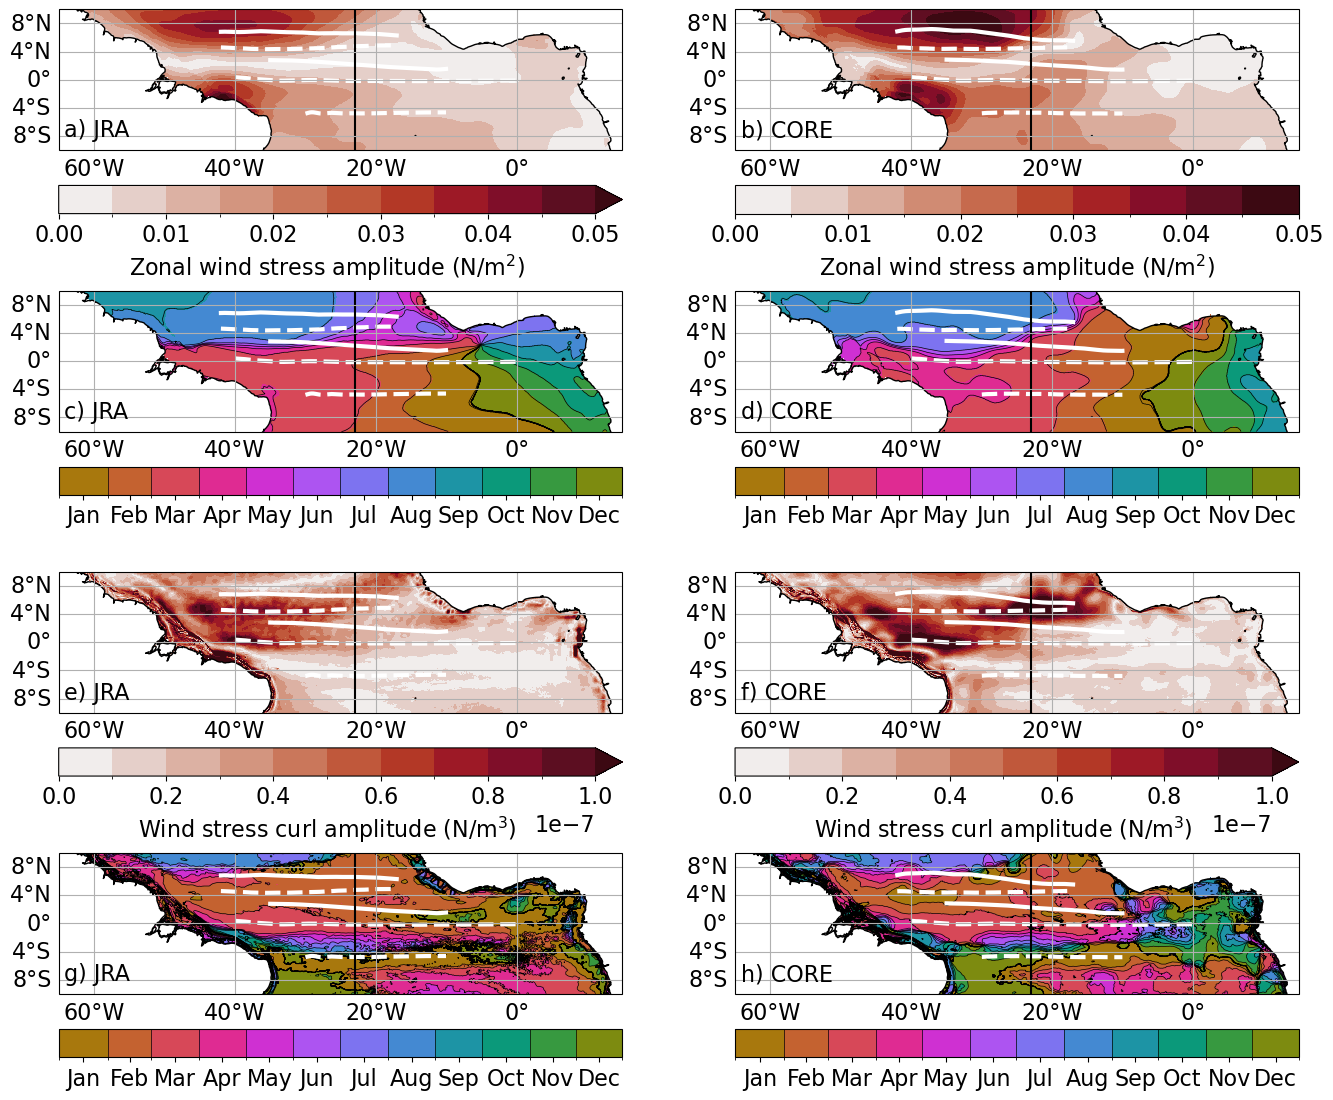

In [25]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tlim1_C,tlim2_C = '1980','2009'
lw=3

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)
data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(16,14),
                         subplot_kw={'projection': data_crs})

## Wind stress
ds = taux_rec_AH.where(taux_harmo.umask==1)

#JRA wind stress
ds.max('time').sel(forcings='JRA').plot(ax=axes[0,0],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11, vmax=0.05,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal wind stress amplitude (N/m$^2$)'})

gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[1,0],ylim=[-10,10],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[1,0],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

#CORE  wind stress
ds.max('time').sel(forcings='CORE').plot(ax=axes[0,1],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11, vmax=0.05,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal wind stress amplitude (N/m$^2$)'})

gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[1,1],ylim=[-10,10],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[1,1],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

## Wind stress curl
ds = tau_curl_rec_AH.where(tau_curl_harmo.fmask==1)

#JRA
ds.max('time').sel(forcings='JRA').plot(ax=axes[2,0],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[3,0],ylim=[-10,10],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[3,0],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

#CORE
ds.max('time').sel(forcings='CORE').plot(ax=axes[2,1],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[3,1],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[3,1],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

plot_YCM_currents('JRA',axes[0,0])
plot_YCM_currents('JRA',axes[1,0])
plot_YCM_currents('CORE',axes[0,1])
plot_YCM_currents('CORE',axes[1,1])

plot_YCM_currents('JRA',axes[2,0])
plot_YCM_currents('JRA',axes[3,0])
plot_YCM_currents('CORE',axes[2,1])
plot_YCM_currents('CORE',axes[3,1])

for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,xlocs=[-60,-40,-20,0],ylocs=[-8,-4,0,4,8])
    gl.top_labels = gl.right_labels = False
    ax.axvline(x=-23, color='k')
    
text_labels = ['a','b','c','d','e','f','g','h']
text_labels2 = ['JRA','CORE','JRA','CORE','JRA','CORE','JRA','CORE']

for i, ax in enumerate(axes.flat):
    ax.text(.01, .06, f'{text_labels[i]}) {text_labels2[i]}', transform=ax.transAxes, ha="left", va="bottom")

if savefig:
    plt.savefig(out_dir+fig_name_0+fig_format,dpi=300,bbox_inches='tight')

# Zonal wind stress curl AH

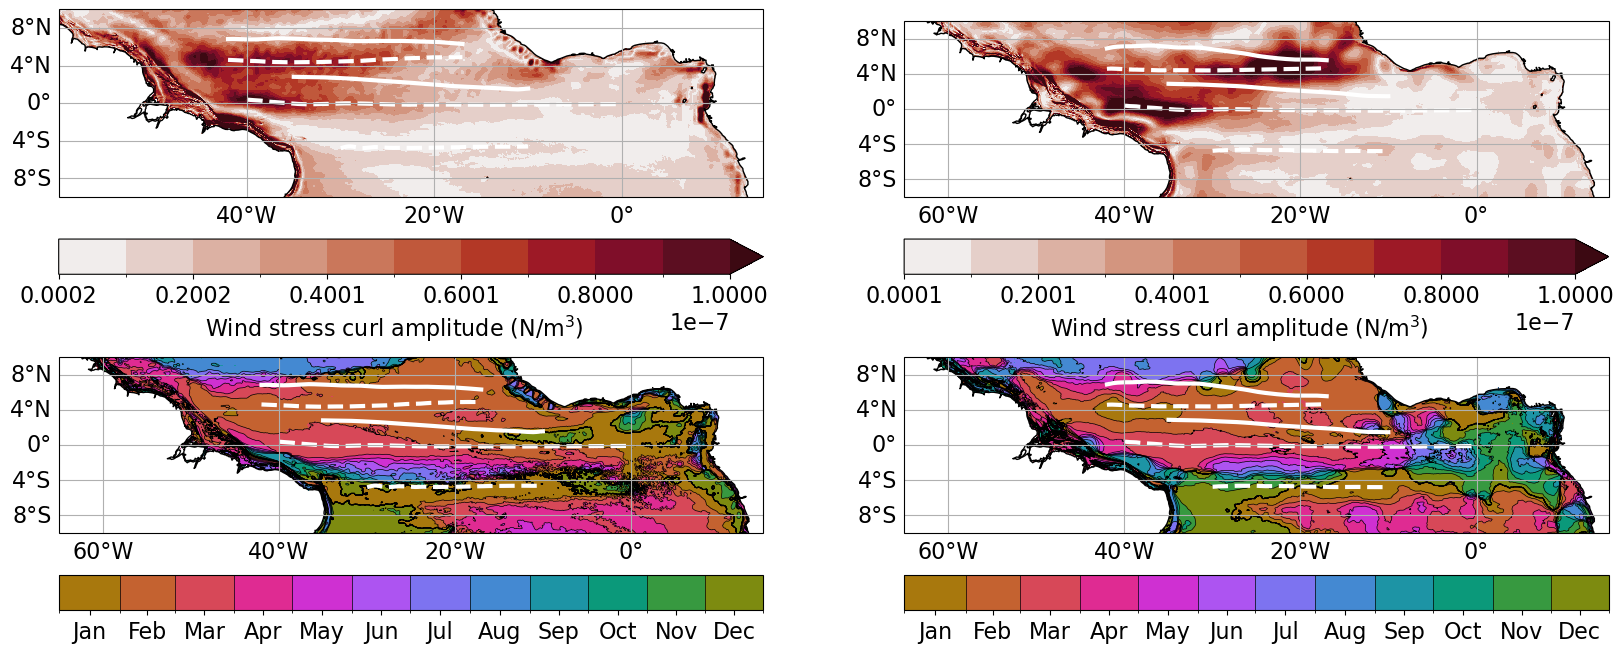

In [26]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tlim1_C,tlim2_C = '1980','2009'
lw=3

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = tau_curl_rec_AH.where(tau_curl_harmo.fmask==1)

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
ds.max('time').sel(forcings='JRA').plot(ax=axes[0,0],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,xlim=[-60,15],
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[1,0],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[1,0],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

#CORE
ds.max('time').sel(forcings='CORE').plot(ax=axes[0,1],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[1,1],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[1,1],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

plot_YCM_currents('JRA',axes[0,0])
plot_YCM_currents('JRA',axes[1,0])
plot_YCM_currents('CORE',axes[0,1])
plot_YCM_currents('CORE',axes[1,1])

for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,xlocs=[-60,-40,-20,0],ylocs=[-8,-4,0,4,8])
    gl.top_labels = gl.right_labels = False
    

if savefig:
    plt.savefig(out_dir+fig_name_1+fig_format,dpi=300,bbox_inches='tight')

# Zonal wind stress curl SH

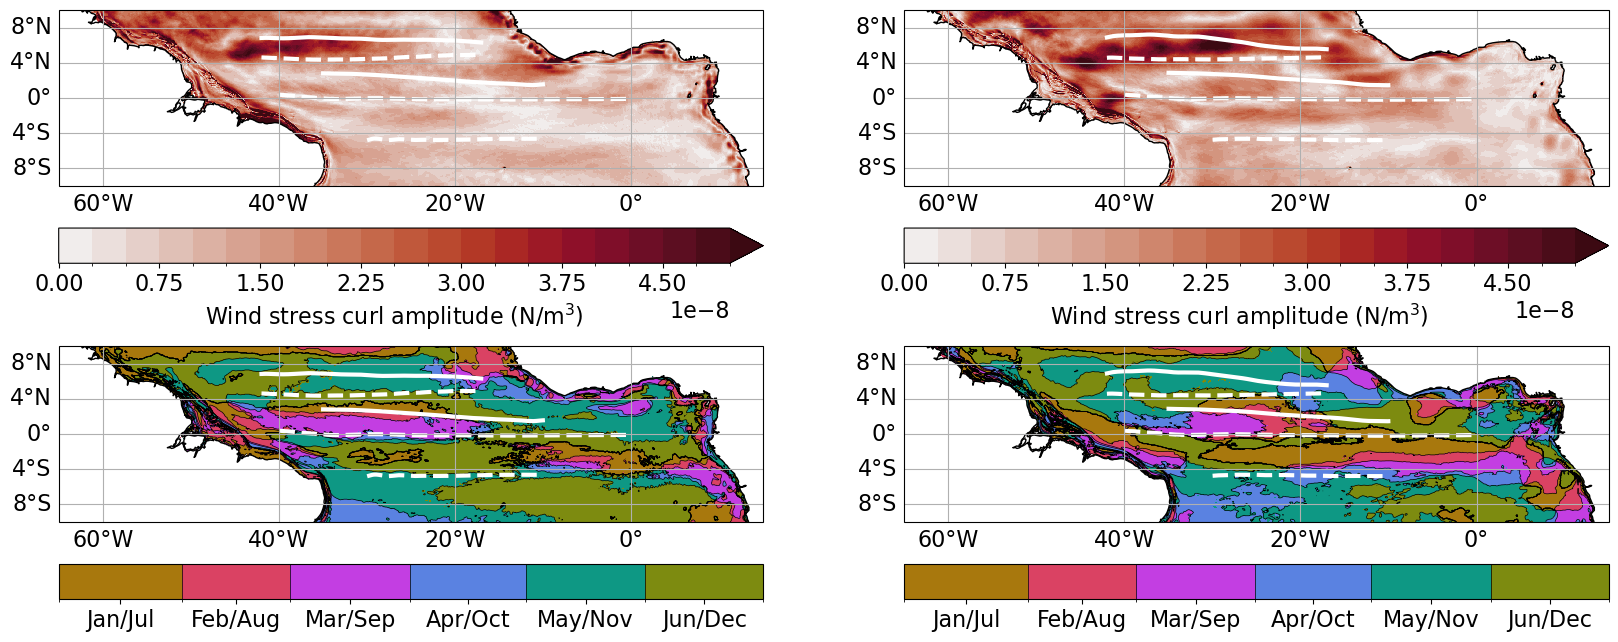

In [27]:
cb_lev = np.array([0,32,60,91,121,152,182.5])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan/Jul','Feb/Aug','Mar/Sep','Apr/Oct','May/Nov','Jun/Dec']
lw=3

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = tau_curl_rec_SH.where(tau_curl_harmo.fmask==1)

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
ds.max('time').sel(forcings='JRA').plot(transform=data_crs,
                      ax=axes[0,0],
                      cmap=co.cm.amp,levels=21,vmax=.5e-7,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})
gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[1,0],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[1,0],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)


#CORE
ds.max('time').sel(forcings='CORE').plot(transform=data_crs,
                      ax=axes[0,1],
                      cmap=co.cm.amp,levels=21,vmax=.5e-7,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})
gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[1,1],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
 
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[1,1],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

plot_YCM_currents('JRA',axes[0,0])
plot_YCM_currents('JRA',axes[1,0])
plot_YCM_currents('CORE',axes[0,1])
plot_YCM_currents('CORE',axes[1,1])

for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,xlocs=[-60,-40,-20,0],ylocs=[-8,-4,0,4,8])
    gl.top_labels = gl.right_labels = False
    

if savefig:
    plt.savefig(out_dir+fig_name_2+fig_format,dpi=300,bbox_inches='tight')

# Zonal wind stress AH

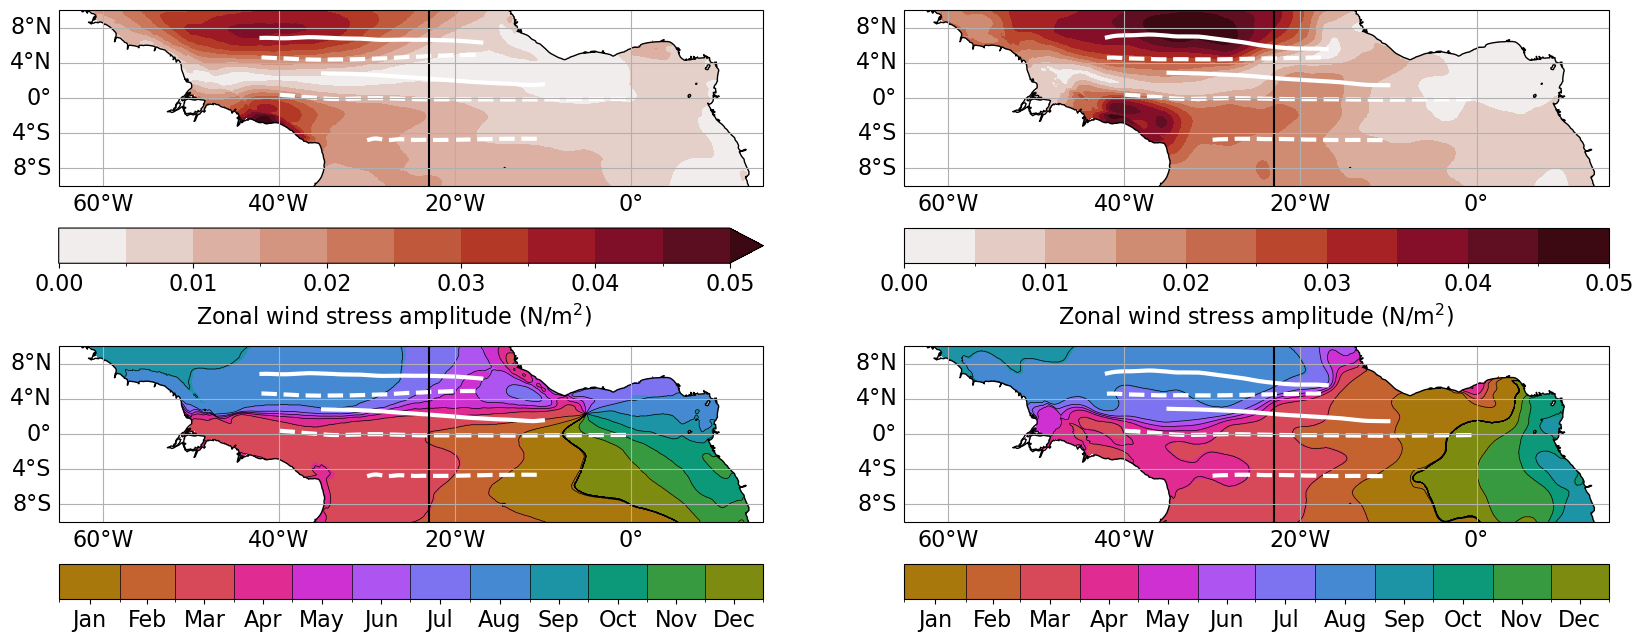

In [28]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tlim1_C,tlim2_C = '1980','2009'
lw=3

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = taux_rec_AH.where(taux_harmo.umask==1)

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
ds.max('time').sel(forcings='JRA').plot(ax=axes[0,0],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11, vmax=0.05,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal wind stress amplitude (N/m$^2$)'})

gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[1,0],ylim=[-10,10],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[1,0],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

#CORE
ds.max('time').sel(forcings='CORE').plot(ax=axes[0,1],ylim=[-10,10],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11, vmax=0.05,vmin=0,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Zonal wind stress amplitude (N/m$^2$)'})

gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[1,1],ylim=[-10,10],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[1,1],ylim=[-10,10],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

plot_YCM_currents('JRA',axes[0,0])
plot_YCM_currents('JRA',axes[1,0])
plot_YCM_currents('CORE',axes[0,1])
plot_YCM_currents('CORE',axes[1,1])


for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,xlocs=[-60,-40,-20,0],ylocs=[-8,-4,0,4,8])
    gl.top_labels = gl.right_labels = False
    ax.axvline(x=-23, color='k')

if savefig:
    plt.savefig(out_dir+fig_name_3+fig_format,dpi=300,bbox_inches='tight')

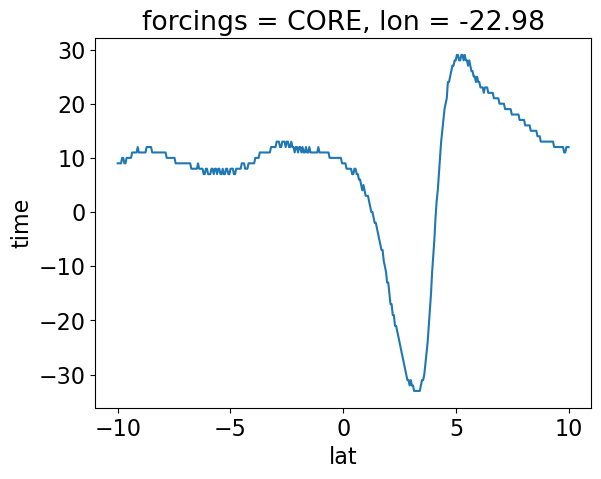

In [29]:
(ds.idxmax('time').diff('forcings')).sel(lon=-23,method='nearest').plot()

# Linear Advection AH

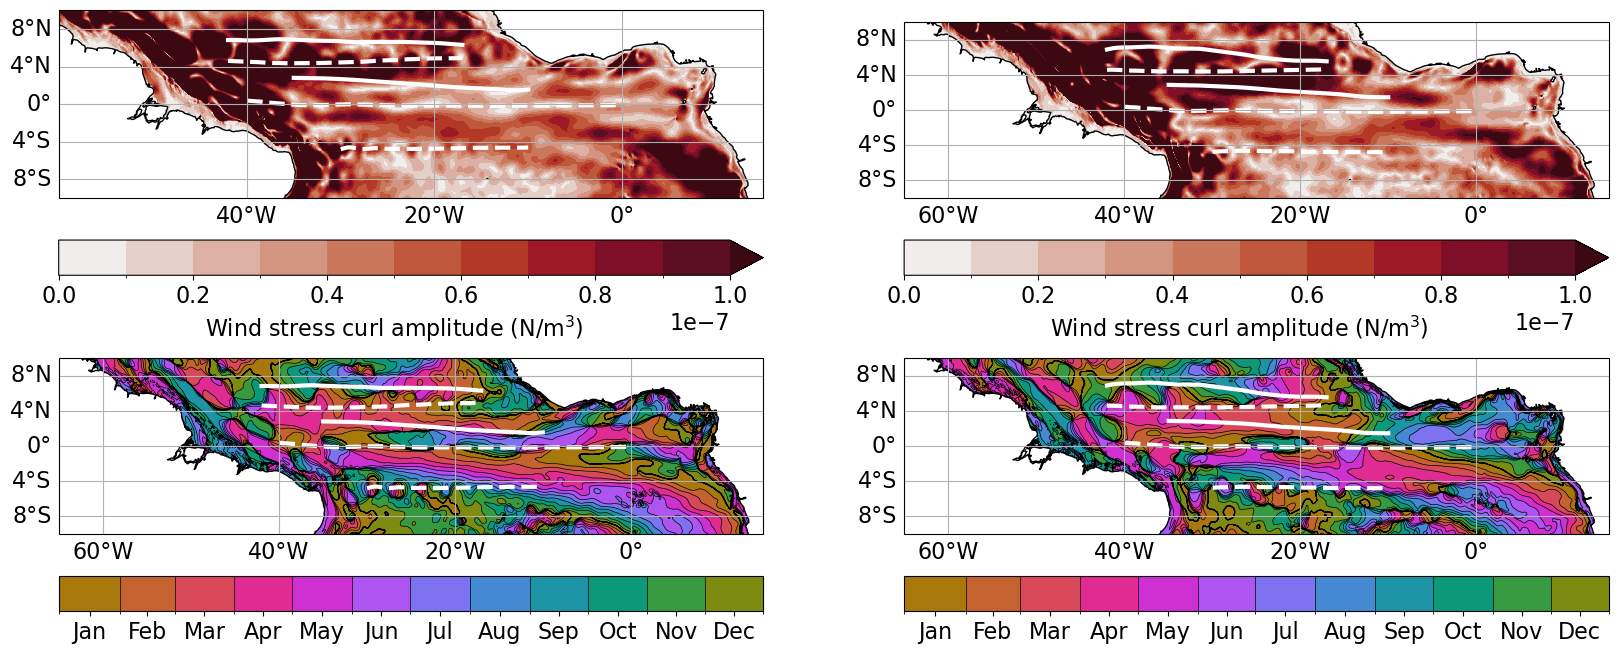

In [30]:
cb_lev = np.array([0,32,60,91,121,152,182,213,244,274,305,335,365])
cb_ticks = cb_lev[:-1]+np.diff(cb_lev)/2
cb_tname = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
tlim1_C,tlim2_C = '1980','2009'
lw=3

cmap = co.cm.phase
newcmap = co.tools.crop_by_percent(cmap, 8, which='max', N=None)

ds = lin_adv_rec_AH.where(lin_adv_rec_AH.vmask==1)

data_crs = ccrs.PlateCarree()

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,8),
                         subplot_kw={'projection': data_crs})

#JRA
ds.max('time').sel(forcings='JRA').plot(ax=axes[0,0],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,xlim=[-60,15],
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='JRA').plot(ax=axes[1,0],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})

CF = ds.idxmax('time').sel(forcings='JRA').plot.contour(ax=axes[1,0],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

#CORE
ds.max('time').sel(forcings='CORE').plot(ax=axes[0,1],
                      transform=data_crs,
                      cmap=co.cm.amp,levels=11,vmax=1e-7,
                      cbar_kwargs={
                     'orientation':'horizontal',
                     'label':'Wind stress curl amplitude (N/m$^3$)'})

gm = ds.idxmax('time').sel(forcings='CORE').plot(ax=axes[1,1],
                      transform=data_crs,
        cmap=newcmap, levels=cb_lev,
        cbar_kwargs={'ticks':cb_ticks,
                     'label':'',
                     'spacing': 'proportional',
                     'orientation':'horizontal'})
CF = ds.idxmax('time').sel(forcings='CORE').plot.contour(ax=axes[1,1],
                      transform=data_crs,
                      colors='k', levels=cb_lev,linewidths=.5)

gm.colorbar.set_ticklabels(cb_tname)
gm.colorbar.add_lines(CF)

plot_YCM_currents('JRA',axes[0,0])
plot_YCM_currents('JRA',axes[1,0])
plot_YCM_currents('CORE',axes[0,1])
plot_YCM_currents('CORE',axes[1,1])

for i,ax in enumerate(axes.flat):
#     ax.axes.axis('tight')
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,xlocs=[-60,-40,-20,0],ylocs=[-8,-4,0,4,8])
    gl.top_labels = gl.right_labels = False
    

if savefig:
    plt.savefig(out_dir+'INALT20_lin_adv_AH_5d_clim_1980_2009'+fig_format,dpi=300,bbox_inches='tight')

## Amplitude of seasonal cycle Guinea Dome
GD_lat, GD_lon = [5,10],[-30,-15]

curl_GD = tau_curl_AM.sel(lat=slice(*GD_lat),lon=slice(*GD_lon)).max('time').mean(['lat','lon']).values
print(f'GD - Wind stress curl (N/m$^3), JRA, CORE:{curl_GD}, ratio {curl_GD[1]/curl_GD[0]}')

In [31]:
GD_lat, GD_lon = [4,8],[-30,-15]
curl_GD = tau_curl_rec_AH.sel(lat=slice(*GD_lat),lon=slice(*GD_lon)).max('time').mean(['lat','lon'])
print(f'Wind stress curl amplitude: {curl_GD.forcings.isel(forcings=0).values} {curl_GD.isel(forcings=0).round(decimals=9).values}')
print(f'Wind stress curl amplitude: {curl_GD.forcings.isel(forcings=1).values} {curl_GD.isel(forcings=1).round(decimals=9).values}')
print(f'Wind stress curl ratio: {curl_GD.forcings.isel(forcings=1).values}/{curl_GD.forcings.isel(forcings=0).values} {(curl_GD.isel(forcings=1)/curl_GD.isel(forcings=0)).round(decimals=9).values}')

Wind stress curl amplitude: JRA 3.9e-08
Wind stress curl amplitude: CORE 7.5e-08
Wind stress curl ratio: CORE/JRA 1.934167277
